<a href="https://colab.research.google.com/github/arunt-sjsu/deep_learning/blob/main/Assignment4/Numpy_Based_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The Goal of this notebook is to build a neural network using numpy alone. The notebook creates the model and showcases the difference between ypred and true y**

In [114]:
import pandas as pd
import numpy as np
df = pd.DataFrame(np.random.randn(10000, 3)*10, columns=list('xyz'))
weights = pd.DataFrame(np.random.randn(10000,1), columns=['weights_a'])
weights['weights_b'] = np.random.randn(10000,1)
weights['weights_c'] = np.random.randn(10000,1)

In [115]:
df["a"] = 2 * weights['weights_a'] * np.square(df['x']) + 8 * weights['weights_b'] * np.power(df['y'],3) - 3 * df['z'] 
df["b"] = 3 * weights['weights_a'] * np.square(df['x']) - 5 * weights['weights_b'] * np.square(df['y']) - 2 * weights['weights_c'] * np.power(df['z'],3) 

In [116]:
df.head()

,x,y,z,a,b
0,-11.998181,4.554299,-1.148945,-632.473511,-863.259155
1,4.973849,-1.260660,-7.260323,17.977222,-305.454721
2,3.268172,3.921728,5.787610,342.625539,148.362627
3,-14.328727,-5.681156,-2.943232,-937.594336,874.565805
4,-3.518270,-4.371326,0.176715,20.348141,66.944940


Neural Network - 3 Layer, 2 Output using Numpy

In [117]:
import numpy as np
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")

from sklearn.metrics import accuracy_score


In [169]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1

X, y = df[["x","y","z"]].to_numpy(),df[["a","b"]].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)


In [184]:
NN_ARCHITECTURE = [
    {"input_dim": 3, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 2, "activation": "relu"},
]

In [171]:
def init_layers(nn_architecture, seed = 99):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

In [175]:
def relu(Z):
    return np.maximum(0,Z)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [13]:
def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)


In [14]:
# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_


In [15]:
def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()


In [29]:
def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory


In [164]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # selection of activation function
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr


In [36]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr


In [122]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    #Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values


In [18]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;


In [19]:
def train(X, Y, nn_architecture, epochs, learning_rate, verbose=False, callback=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        # step forward
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        
        # calculating metrics and saving them in history
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # step backward - calculating gradient
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values


In [157]:
# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 100, 0.01)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


In [62]:
import pprint
pp = pprint.PrettyPrinter(depth=4)
pp.pprint(params_values)


{'W1': array([[-2.50917216e+02,  4.83436618e+02, -9.19461764e+01],
       [-6.57406616e+00, -2.48045682e+00, -1.44678591e+01],
       [-1.51119540e+01, -6.65790822e+00, -8.90639165e+00],
       [ 1.95764804e+02,  6.22421416e+01,  2.62228437e+01],
       [-7.99487007e+00,  6.94373973e+00, -5.09032138e+00],
       [-2.88321122e+02,  1.25604564e+02, -2.60035593e+01],
       [-5.55476651e+01,  1.27379671e+02,  1.08157898e+01],
       [ 2.01571153e+02, -4.68920066e+02,  1.60082137e+02],
       [-2.48556966e+02,  1.95576545e+02,  5.00922487e+00],
       [ 2.04356986e+02, -1.55776833e+02, -7.76734659e+00],
       [-6.91789274e+01,  2.07152450e+02, -7.06509310e+01],
       [ 3.92151848e+02, -5.95932213e+02,  2.10033332e+02],
       [-1.68058149e+01,  5.79663646e+00,  2.36645231e-01],
       [ 1.11590755e+01,  1.00485022e+00,  8.60833406e+00],
       [-1.07808600e+01,  2.98778111e+02, -7.90237984e+01],
       [ 2.28608456e+02, -5.19330429e+02,  1.78166006e+02],
       [ 2.60379034e+02,  6.55978

In [231]:
# boundary of the graph
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2
GRID_Z_START = -1.5
GRID_Z_END = 2.5
GRID_Z_START = -1.0
GRID_Z_END = 2
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j,GRID_Z_START:GRID_Z_END:100j]
print(grid.shape)
grid_2d = grid.reshape(3, -1).T
XX, YY, ZZ = grid


(3, 100, 100, 100)


In [229]:
# the function making up the graph of a dataset
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    fig, axes = plt.subplots(2)
    axes[0].set_title(plot_name, fontsize=30)
    axes[0].scatter(X[:, 0], X[:, 1], c=y[:,0].ravel(), s=20, cmap=plt.cm.Spectral, edgecolors='blue')
    axes[1].scatter(X[:, 0], X[:, 1], c=y[:,1].ravel(), s=30, cmap=plt.cm.Spectral, edgecolors='black')
    plt.show()

In [209]:
def callback_numpy_plot(index, params):
    plot_title = "NumPy Model - It: {:05}".format(index)
    file_name = "numpy_model_{:05}.png".format(index//50)
    prediction_probs, _ = full_forward_propagation(np.transpose(grid_2d), params, NN_ARCHITECTURE)
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 2)
    make_plot(X_test, y_test, plot_title, XX=XX, YY=YY, preds=prediction_probs, dark=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


<Figure size 1152x864 with 0 Axes>

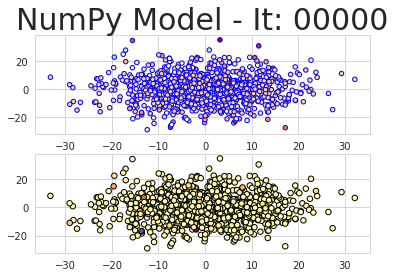

<Figure size 1152x864 with 0 Axes>

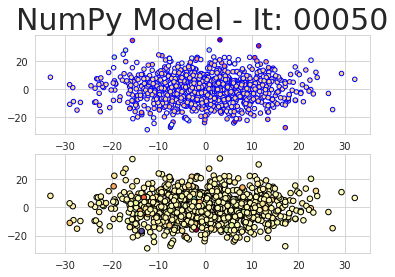

<Figure size 1152x864 with 0 Axes>

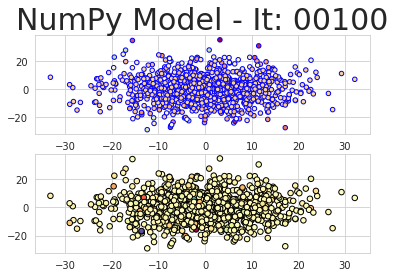

<Figure size 1152x864 with 0 Axes>

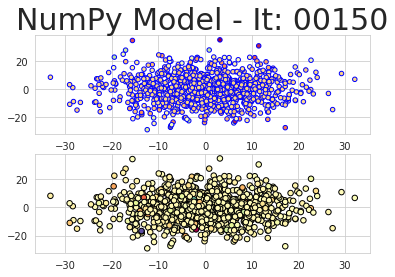

<Figure size 1152x864 with 0 Axes>

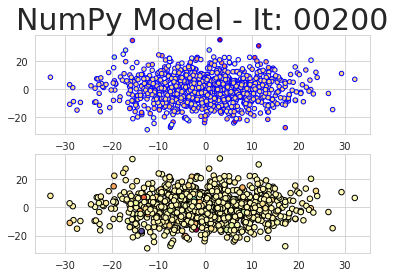

<Figure size 1152x864 with 0 Axes>

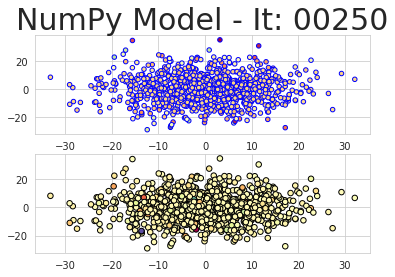

<Figure size 1152x864 with 0 Axes>

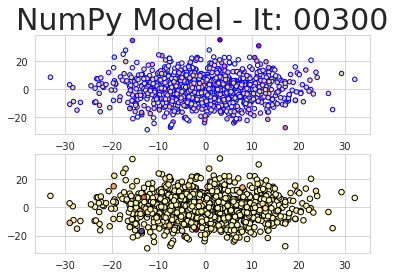

<Figure size 1152x864 with 0 Axes>

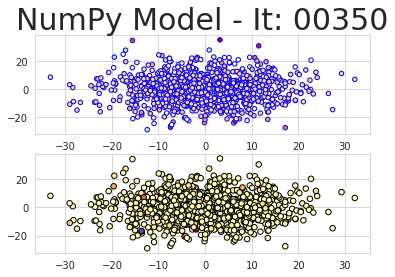

<Figure size 1152x864 with 0 Axes>

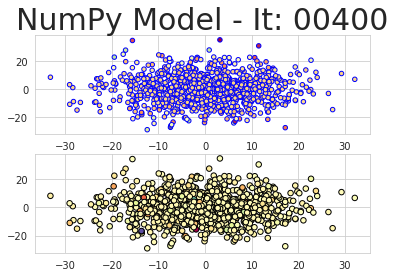

<Figure size 1152x864 with 0 Axes>

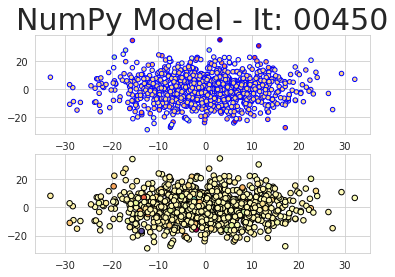

<Figure size 1152x864 with 0 Axes>

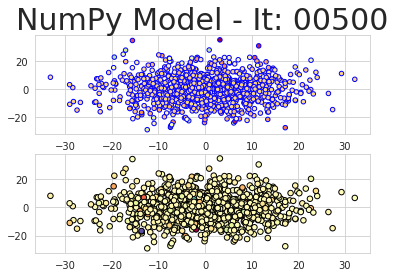

<Figure size 1152x864 with 0 Axes>

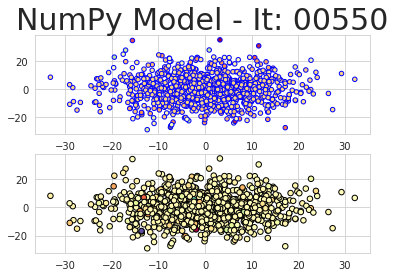

<Figure size 1152x864 with 0 Axes>

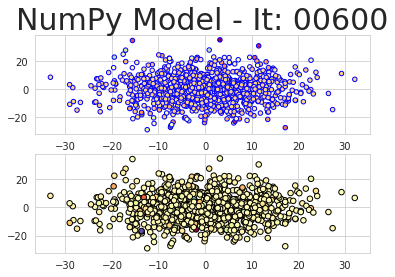

<Figure size 1152x864 with 0 Axes>

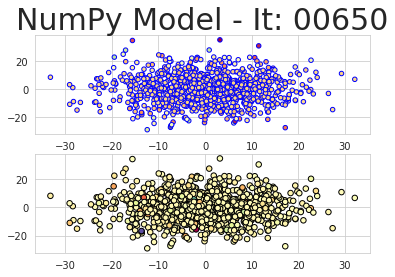

<Figure size 1152x864 with 0 Axes>

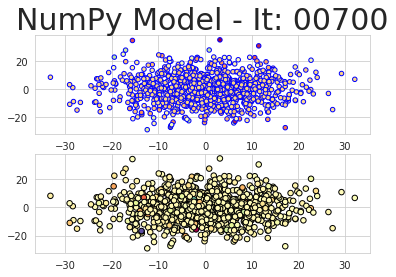

<Figure size 1152x864 with 0 Axes>

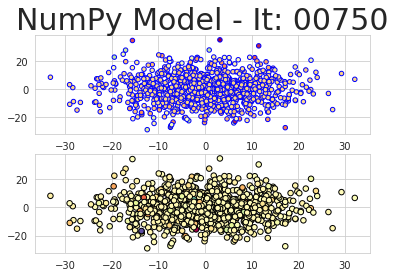

<Figure size 1152x864 with 0 Axes>

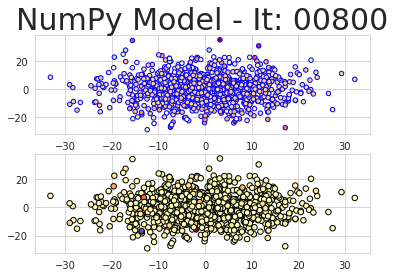

<Figure size 1152x864 with 0 Axes>

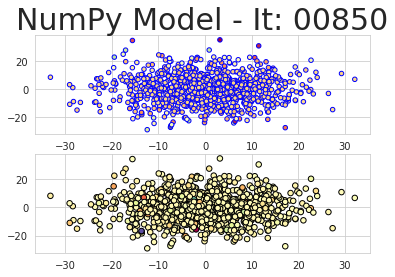

<Figure size 1152x864 with 0 Axes>

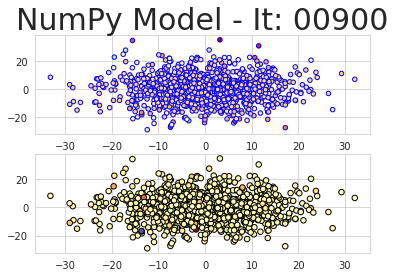

<Figure size 1152x864 with 0 Axes>

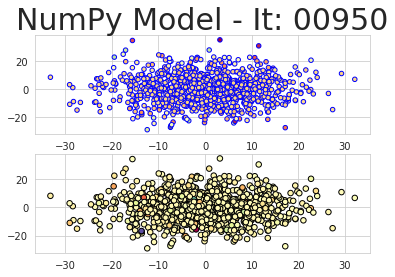

In [230]:
# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 2))), NN_ARCHITECTURE, 1000, 0.01, False, callback_numpy_plot)


<Figure size 1152x864 with 0 Axes>

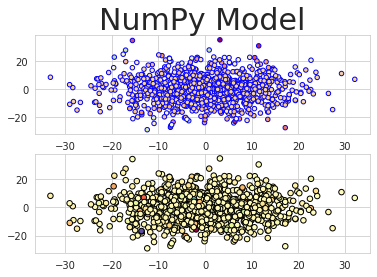

In [232]:
prediction_probs_numpy, _ = full_forward_propagation(np.transpose(grid_2d), params_values, NN_ARCHITECTURE)
prediction_probs_numpy = prediction_probs_numpy.reshape(prediction_probs_numpy.shape[1], 2)
make_plot(X_test, y_test, "NumPy Model", file_name=None, XX=XX, YY=YY, preds=prediction_probs_numpy)
